In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/individual-seasonal-trend-residual-dataframes/df_residual.csv
/kaggle/input/individual-seasonal-trend-residual-dataframes/df_trend.csv
/kaggle/input/individual-seasonal-trend-residual-dataframes/df_seasonal.csv


In [62]:
!pip install feature-engine

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import random
#import shap
import optuna
import joblib
#!pip install openpyxl
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [64]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if y_true.ndim > 1:
        y_true = y_true.flatten()  # Flatten if y_true is 2-dimensional
    if y_pred.ndim > 1:
        y_pred = y_pred.flatten()  # Flatten if y_pred is 2-dimensional

    non_zero_mask = (y_true != 0) & (y_pred != 0)  # Exclude zero values from calculation
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if len(y_true) != 0 else np.nan

In [65]:
df = pd.read_csv('/kaggle/input/individual-seasonal-trend-residual-dataframes/df_seasonal.csv')
df

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Seasonal
0,2019-01-01 00:00:00,0,0,1,1,2019,1,-62.946317
1,2019-01-01 01:00:00,0,0,2,1,2019,1,-72.182077
2,2019-01-01 02:00:00,0,0,3,1,2019,1,-73.449614
3,2019-01-01 03:00:00,0,0,4,1,2019,1,-73.517630
4,2019-01-01 04:00:00,0,0,5,1,2019,1,-67.510447
...,...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,20,4,2024,4,-13.215410
46460,2024-04-19 20:00:00,0,0,21,4,2024,4,24.998571
46461,2024-04-19 21:00:00,0,0,22,4,2024,4,-22.917023
46462,2024-04-19 22:00:00,0,0,23,4,2024,4,-18.455391


In [66]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%Y-%m-%d %H:%M:%S')
#df.drop(columns='OneHourSlot',inplace=True)
#df['hour'] = df['Date_Time'].dt.hour
df

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Seasonal
0,2019-01-01 00:00:00,0,0,1,1,2019,1,-62.946317
1,2019-01-01 01:00:00,0,0,2,1,2019,1,-72.182077
2,2019-01-01 02:00:00,0,0,3,1,2019,1,-73.449614
3,2019-01-01 03:00:00,0,0,4,1,2019,1,-73.517630
4,2019-01-01 04:00:00,0,0,5,1,2019,1,-67.510447
...,...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,20,4,2024,4,-13.215410
46460,2024-04-19 20:00:00,0,0,21,4,2024,4,24.998571
46461,2024-04-19 21:00:00,0,0,22,4,2024,4,-22.917023
46462,2024-04-19 22:00:00,0,0,23,4,2024,4,-18.455391


In [67]:
df.drop(columns='OneHourSlot', inplace=True)

In [68]:
df.head(3)

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal
0,2019-01-01 00:00:00,0,0,1,2019,1,-62.946317
1,2019-01-01 01:00:00,0,0,1,2019,1,-72.182077
2,2019-01-01 02:00:00,0,0,1,2019,1,-73.449614


# filtering out the df from 1st Jan 2019 to 20th April 2024

In [69]:
# Define start and end dates
start_date = pd.Timestamp(2019, 1, 1)
end_date = pd.Timestamp(2024, 4, 20)

# Filter the DataFrame
df = df[(df['Date_Time'] >= start_date) & (df['Date_Time'] < end_date)]
df

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal
0,2019-01-01 00:00:00,0,0,1,2019,1,-62.946317
1,2019-01-01 01:00:00,0,0,1,2019,1,-72.182077
2,2019-01-01 02:00:00,0,0,1,2019,1,-73.449614
3,2019-01-01 03:00:00,0,0,1,2019,1,-73.517630
4,2019-01-01 04:00:00,0,0,1,2019,1,-67.510447
...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,4,2024,4,-13.215410
46460,2024-04-19 20:00:00,0,0,4,2024,4,24.998571
46461,2024-04-19 21:00:00,0,0,4,2024,4,-22.917023
46462,2024-04-19 22:00:00,0,0,4,2024,4,-18.455391


In [70]:
sp = 'Voltas_Gate_Thane_Station_West'

In [71]:
# Setting seeds for random number generators in different libraries ensures reproducibility of results.

random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

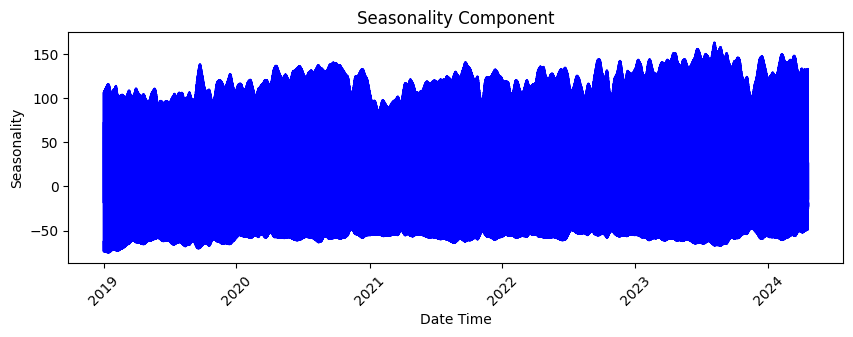

In [72]:
# Plotting the graph
plt.figure(figsize=(10, 3))  # Set the width and height of the figure
plt.plot(df['Date_Time'].to_numpy(), df['Seasonal'].to_numpy(), color='blue')
plt.title(f"Seasonality Component")
plt.xlabel('Date Time')  # X-axis label
plt.ylabel('Seasonality')  # Y-axis label
plt.tick_params('x', labelrotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()


In [73]:
df['Seasonal'].to_numpy()

array([-62.94631734, -72.18207737, -73.44961361, ..., -22.91702318,
       -18.45539101, -24.13831737])

In [74]:
df.loc[df['Seasonal'] < 0, 'Seasonal'] = 0

In [75]:
df['Seasonal']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
46459     0.000000
46460    24.998571
46461     0.000000
46462     0.000000
46463     0.000000
Name: Seasonal, Length: 46464, dtype: float64

In [76]:
df

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal
0,2019-01-01 00:00:00,0,0,1,2019,1,0.000000
1,2019-01-01 01:00:00,0,0,1,2019,1,0.000000
2,2019-01-01 02:00:00,0,0,1,2019,1,0.000000
3,2019-01-01 03:00:00,0,0,1,2019,1,0.000000
4,2019-01-01 04:00:00,0,0,1,2019,1,0.000000
...,...,...,...,...,...,...,...
46459,2024-04-19 19:00:00,0,0,4,2024,4,0.000000
46460,2024-04-19 20:00:00,0,0,4,2024,4,24.998571
46461,2024-04-19 21:00:00,0,0,4,2024,4,0.000000
46462,2024-04-19 22:00:00,0,0,4,2024,4,0.000000


In [77]:
df.to_csv('input_file_1.csv', index=False)
print("this file contains : ", df.head(3))

this file contains :              Date_Time  Is_Holiday  Holiday_Type  Month  Year  Weekday  \
0 2019-01-01 00:00:00           0             0      1  2019        1   
1 2019-01-01 01:00:00           0             0      1  2019        1   
2 2019-01-01 02:00:00           0             0      1  2019        1   

   Seasonal  
0       0.0  
1       0.0  
2       0.0  


In [78]:
# create lag features

lag_transformer = LagFeatures(variables=['Seasonal'], periods=[1,2,24,24*7,24*14,24*21,24*28])
df = lag_transformer.fit_transform(df)


In [79]:
df.head()

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
0,2019-01-01 00:00:00,0,0,1,2019,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01 01:00:00,0,0,1,2019,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01 02:00:00,0,0,1,2019,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2019-01-01 03:00:00,0,0,1,2019,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2019-01-01 04:00:00,0,0,1,2019,1,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [80]:
df.tail()

,Date_Time,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
46459,2024-04-19 19:00:00,0,0,4,2024,4,0.000000,3.135115,26.843958,0.000000,0.000000,10.341876,18.431855,22.763349
46460,2024-04-19 20:00:00,0,0,4,2024,4,24.998571,0.000000,3.135115,24.160515,18.796946,15.932651,7.417508,4.404355
46461,2024-04-19 21:00:00,0,0,4,2024,4,0.000000,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46462,2024-04-19 22:00:00,0,0,4,2024,4,0.000000,0.000000,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000
46463,2024-04-19 23:00:00,0,0,4,2024,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [81]:
df.to_csv('input_file_2.csv', index=False)
print(df.head(3))

            Date_Time  Is_Holiday  Holiday_Type  Month  Year  Weekday  \
0 2019-01-01 00:00:00           0             0      1  2019        1   
1 2019-01-01 01:00:00           0             0      1  2019        1   
2 2019-01-01 02:00:00           0             0      1  2019        1   

   Seasonal  Seasonal_lag_1  Seasonal_lag_2  Seasonal_lag_24  \
0       0.0             NaN             NaN              NaN   
1       0.0             0.0             NaN              NaN   
2       0.0             0.0             0.0              NaN   

   Seasonal_lag_168  Seasonal_lag_336  Seasonal_lag_504  Seasonal_lag_672  
0               NaN               NaN               NaN               NaN  
1               NaN               NaN               NaN               NaN  
2               NaN               NaN               NaN               NaN  


In [82]:
# create X & y for modelling (Feature Matrix X and Y )

df = df.dropna()
X = df.drop(columns=['Date_Time','Seasonal']) # Feature Matrix X
y = df['Seasonal'] # Target Variable

In [83]:
X

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
672,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
673,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
674,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
675,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
676,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,4,2024,4,3.135115,26.843958,0.000000,0.000000,10.341876,18.431855,22.763349
46460,0,0,4,2024,4,0.000000,3.135115,24.160515,18.796946,15.932651,7.417508,4.404355
46461,0,0,4,2024,4,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46462,0,0,4,2024,4,0.000000,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000


In [84]:
y

672       0.000000
673       0.000000
674       0.000000
675       0.000000
676       0.000000
           ...    
46459     0.000000
46460    24.998571
46461     0.000000
46462     0.000000
46463     0.000000
Name: Seasonal, Length: 45792, dtype: float64

In [85]:
# split into train & test

X_train = X.iloc[:int(np.round((0.95*len(X)))),:]
X_test = X.iloc[int(np.round((0.95*len(X)))):,:]
y_train = y[:int(np.round((0.95*len(X))))]
y_test = y[int(np.round((0.95*len(X)))):]

In [86]:
X_train 

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
672,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
673,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
674,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
675,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
676,0,0,1,2019,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
44169,0,0,1,2024,0,127.995631,42.605070,76.142519,79.479178,82.166545,81.182570,80.004886
44170,0,0,1,2024,0,75.523973,127.995631,39.028225,32.097777,29.360329,31.603537,30.731380
44171,0,0,1,2024,0,39.607856,75.523973,2.702428,5.594347,4.665019,1.963551,4.374845
44172,0,0,1,2024,0,1.952916,39.607856,7.173545,8.544849,14.533242,10.613765,12.348118


In [87]:
y_train

672       0.000000
673       0.000000
674       0.000000
675       0.000000
676       0.000000
           ...    
44169    75.523973
44170    39.607856
44171     1.952916
44172     7.376839
44173     0.000000
Name: Seasonal, Length: 43502, dtype: float64

In [88]:
X_test

,Is_Holiday,Holiday_Type,Month,Year,Weekday,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
44174,0,0,1,2024,0,0.000000,7.376839,0.000000,0.000000,0.000000,0.000000,0.000000
44175,0,0,1,2024,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44176,0,0,1,2024,0,0.000000,0.000000,7.402521,3.757941,7.577407,4.429986,0.000000
44177,0,0,1,2024,0,8.055435,0.000000,27.716317,41.129677,51.670965,45.790227,48.992196
44178,0,0,1,2024,0,26.185095,8.055435,22.659688,15.325175,5.156377,8.948433,15.131969
...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,4,2024,4,3.135115,26.843958,0.000000,0.000000,10.341876,18.431855,22.763349
46460,0,0,4,2024,4,0.000000,3.135115,24.160515,18.796946,15.932651,7.417508,4.404355
46461,0,0,4,2024,4,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
46462,0,0,4,2024,4,0.000000,24.998571,0.000000,0.000000,0.000000,0.000000,0.000000


In [89]:
y_test

44174     0.000000
44175     0.000000
44176     8.055435
44177    26.185095
44178    24.372202
           ...    
46459     0.000000
46460    24.998571
46461     0.000000
46462     0.000000
46463     0.000000
Name: Seasonal, Length: 2290, dtype: float64

In [90]:
sc_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))
joblib.dump(sc_X, f'/kaggle/working/scaler_X_{sp}.joblib')

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))
joblib.dump(sc_y, f'/kaggle/working/scaler_y_{sp}.joblib')

['/kaggle/working/scaler_y_Voltas_Gate_Thane_Station_West.joblib']

In [91]:
sc_X

MinMaxScaler()

In [92]:
sc_y

MinMaxScaler()

In [93]:
# normalizing test set & reshape

X_test_scaled = sc_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

path_best_model = f"/kaggle/working/{sp}.keras"
best_loss = 100

In [94]:
X_test_scaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.04651847, 0.02719613,
        0.        ],
       ...,
       [0.        , 0.        , 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27272727, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.27272727, ..., 0.        , 0.        ,
        0.        ]])

In [95]:
def objective(trial):
    es = EarlyStopping(patience=5)

    # Adding 1st LSTM Layer
    regressor = Sequential() # kerasnsequential model 
    regressor.add(LSTM(units=trial.suggest_int('lstm', 2, 512), return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(trial.suggest_categorical('dropout', [0.1, 0.2, 0.4, 0.6, 0.8])))

    # Adding 2nd LSTM layer
    regressor.add(LSTM(units=trial.suggest_int('lstm_2', 2, 512), return_sequences=False))

    # Output layer
    regressor.add(Dense(units=1)) # single dense layer with single unit 

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    history = regressor.fit(X_train_scaled_2, y_train_scaled,  batch_size= trial.suggest_int('bs',32,512), epochs = 200,validation_split=0.1, callbacks=[es],shuffle=False)

    loss = history.history['val_loss'][-1]
    global best_loss
    if loss < best_loss:
        regressor.save(path_best_model)
        best_loss = loss
    del regressor
    return loss

study = optuna.create_study(
direction='minimize',
load_if_exists=True)
study.optimize(objective, n_trials=5)

[I 2024-09-07 10:01:49,677] A new study created in memory with name: no-name-01f345e6-aaea-4879-822f-1e54fb87be6e


Epoch 1/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.5463e-04 - val_loss: 0.0015
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.0770e-04 - val_loss: 0.0013
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.0786e-04 - val_loss: 0.0012
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.6257e-04 - val_loss: 0.0013
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.1006e-04 - val_loss: 0.0012
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.7293e-04 - val_loss: 0.0011
Epoch 8/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.4418e-04 - val_loss: 0.0010
Epoch 9/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.8719e-04 - val_loss: 6.9696e-04
Epoch 10/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.0478e-04 - val_loss: 6.1059e-04
Epoch 11/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.5734e-04 -

[I 2024-09-07 10:03:01,457] Trial 0 finished with value: 0.0001701752480585128 and parameters: {'lstm': 375, 'dropout': 0.2, 'lstm_2': 126, 'bs': 250}. Best is trial 0 with value: 0.0001701752480585128.


Epoch 1/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 2/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 3/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 4/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.9897e-04 - val_loss: 0.0014
Epoch 6/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.1099e-04 - val_loss: 0.0014
Epoch 7/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.2707e-04 - val_loss: 0.0012
Epoch 8/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.5400e-04 - val_loss: 0.0012
Epoch 9/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.7978e-04 - val_loss: 0.0011
Epoch 10/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.3920e-04 - val_loss: 0.0011
Epoch 11/200
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 6.9007e-04 - val_loss: 9.2814e-04
Epoch 12/200
82/82 ━

[I 2024-09-07 10:04:14,993] Trial 1 finished with value: 0.0006997817545197904 and parameters: {'lstm': 467, 'dropout': 0.4, 'lstm_2': 324, 'bs': 483}. Best is trial 0 with value: 0.0001701752480585128.


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0073 - val_loss: 0.0016
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.7195e-04 - val_loss: 0.0014
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.9590e-04 - val_loss: 0.0011
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.8052e-04 - val_loss: 0.0012
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.1841e-04 - val_loss: 0.0012
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.3569e-04 - val_loss: 9.5122e-04
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.5978e-04 - val_loss: 5.5393e-04
Epoch 9/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 5.2537e-04 - val_loss: 6.1867e-04
Epoch 10/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.5984e-04 - val_loss: 5.0016e-04
Epoch 11/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 4.0336e-

[I 2024-09-07 10:06:08,525] Trial 2 finished with value: 0.00018107403593603522 and parameters: {'lstm': 508, 'dropout': 0.2, 'lstm_2': 383, 'bs': 318}. Best is trial 0 with value: 0.0001701752480585128.


Epoch 1/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0066 - val_loss: 0.0016
Epoch 2/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 3/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.2512e-04 - val_loss: 0.0011
Epoch 5/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.7289e-04 - val_loss: 0.0012
Epoch 6/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.8605e-04 - val_loss: 0.0010
Epoch 7/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.1966e-04 - val_loss: 7.1518e-04
Epoch 8/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.0923e-04 - val_loss: 5.9677e-04
Epoch 9/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.0695e-04 - val_loss: 6.1990e-04
Epoch 10/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.6150e-04 - val_loss: 4.3144e-04
Epoch 11/200
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 3.8951e-04 -

[I 2024-09-07 10:07:40,023] Trial 3 finished with value: 0.00018700955843087286 and parameters: {'lstm': 365, 'dropout': 0.1, 'lstm_2': 406, 'bs': 285}. Best is trial 0 with value: 0.0001701752480585128.


Epoch 1/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0082 - val_loss: 0.0013
Epoch 2/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.6347e-04 - val_loss: 0.0014
Epoch 4/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.4615e-04 - val_loss: 0.0012
Epoch 5/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.4901e-04 - val_loss: 0.0012
Epoch 6/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.9607e-04 - val_loss: 0.0012
Epoch 7/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6508e-04 - val_loss: 0.0011
Epoch 8/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.7476e-04 - val_loss: 8.1272e-04
Epoch 9/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.2022e-04 - val_loss: 8.0268e-04
Epoch 10/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.0817e-04 - val_loss: 5.8661e-04
Epoch 11/200
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.5097e-04 - val_loss:

[I 2024-09-07 10:08:33,589] Trial 4 finished with value: 0.00020839509670622647 and parameters: {'lstm': 103, 'dropout': 0.4, 'lstm_2': 349, 'bs': 249}. Best is trial 0 with value: 0.0001701752480585128.


In [96]:
# predict on test set

model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
pred_inverse = model.predict(X_test_scaled_2)
pred_2 = sc_y.inverse_transform(pred_inverse)
pred = np.floor(pred_2)
pred = np.where(pred<0, 0, pred)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [97]:
rmse=mean_squared_error(y_test,pred,squared=False)
rscore=r2_score(y_test,pred)
mape=mean_absolute_percentage_error(y_test,pred)
mae=mean_absolute_error(y_test,pred)
print('rmse:', mean_squared_error(y_test,pred,squared=False))
print('r2:', r2_score(y_test,pred))
print('mape:', mean_absolute_percentage_error(y_test,pred))
print('mae:', mean_absolute_error(y_test,pred))

rmse: 2.8259276071824386
r2: 0.9916183800303708
mape: 22.23212502226069
mae: 1.6506567703471362


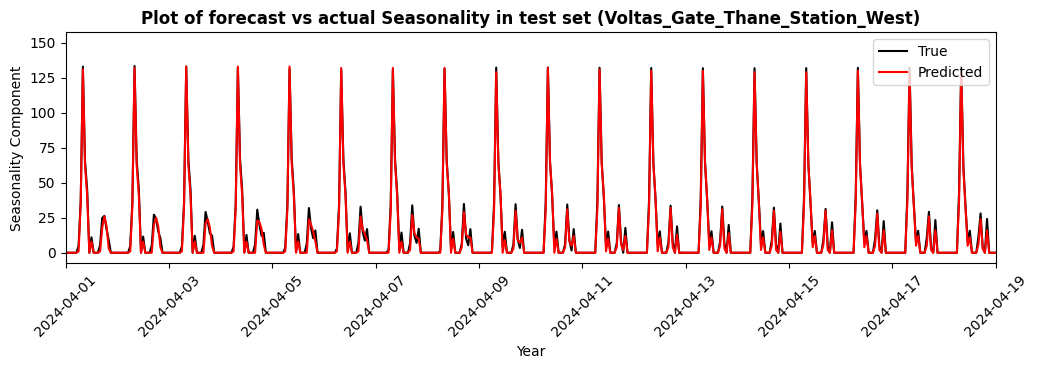

In [98]:
ind = X_test.index
xlabel = df.loc[ind,'Date_Time'].to_numpy()
plt.figure(figsize=(12, 3))
plt.plot(xlabel,y_test.to_numpy(),c='black',label='True')
plt.plot(xlabel,pred,label='Predicted',c='red')
plt.legend(loc=1)
plt.title(f'Plot of forecast vs actual Seasonality in test set ({sp})',fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Seasonality Component')
plt.xlim((pd.Timestamp(2024,4,1),pd.Timestamp(2024,4,19)))
plt.tick_params('x',labelrotation=45)

In [99]:
# Save the figure
plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [100]:
best_params = study.best_params

In [101]:
best_params

{'lstm': 375, 'dropout': 0.2, 'lstm_2': 126, 'bs': 250}

# Append to Excel Function

In [102]:
def append_to_excel(file_path, data):
    try:
        # Load existing workbook or create a new one
        try:
            wb = load_workbook(file_path)
            ws = wb.active
        except FileNotFoundError:
            wb = Workbook()
            ws = wb.active
            ws.append(['sp',"All Years", 'lstm', 'dropout', 'lstm_2', 'bs', 'rmse', 'r2', 'mae', 'mape'])

        # Append data to the next available row
        ws.append(data)

        # Save the workbook
        wb.save(file_path)
        print("Data appended to Excel file successfully.")
    except Exception as e:
        print(f"Error: {e}")
lstm_value = best_params['lstm']
dropout_value = best_params['dropout']
lstm_2_value = best_params['lstm_2']
bs_value = best_params['bs']
            
# Append the data to the Excel file
data_to_append = [sp,"All Years", lstm_value, dropout_value, lstm_2_value, bs_value,rmse,rscore,mape,mae]
file_path = '/kaggle/working/Result.xlsx'
append_to_excel(file_path, data_to_append)

Data appended to Excel file successfully.


# 1st Jan 2022 to 1st June 2022

In [103]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

# Load the dataset
df = pd.read_csv('/kaggle/input/individual-seasonal-trend-residual-dataframes/df_seasonal.csv')

# Create lag features
lag_transformer = LagFeatures(variables=['Seasonal'], periods=[1, 2, 24, 24*7, 24*14, 24*21, 24*28])
df = lag_transformer.fit_transform(df)

# Drop rows with missing values after creating lag features
df = df.dropna()

# Create X (features) and y (target)
X = df.drop(columns=['Date_Time', 'Seasonal'])
y = df['Seasonal']

# X and y are now ready for modeling


In [104]:
df.head(3)

,Date_Time,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Seasonal,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
672,2019-01-29 00:00:00,0,0,1,1,2019,1,-63.708124,-45.124924,-42.579945,-63.686455,-64.934960,-66.262929,-64.998123,-62.946317
673,2019-01-29 01:00:00,0,0,2,1,2019,1,-70.750910,-63.708124,-45.124924,-70.778905,-72.394609,-74.098984,-73.500706,-72.182077
674,2019-01-29 02:00:00,0,0,3,1,2019,1,-71.203272,-70.750910,-63.708124,-71.238425,-72.954441,-74.737855,-74.295151,-73.449614


In [105]:
X

,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Seasonal_lag_1,Seasonal_lag_2,Seasonal_lag_24,Seasonal_lag_168,Seasonal_lag_336,Seasonal_lag_504,Seasonal_lag_672
672,0,0,1,1,2019,1,-45.124924,-42.579945,-63.686455,-64.934960,-66.262929,-64.998123,-62.946317
673,0,0,2,1,2019,1,-63.708124,-45.124924,-70.778905,-72.394609,-74.098984,-73.500706,-72.182077
674,0,0,3,1,2019,1,-70.750910,-63.708124,-71.238425,-72.954441,-74.737855,-74.295151,-73.449614
675,0,0,4,1,2019,1,-71.203272,-70.750910,-71.236869,-72.940186,-74.733035,-74.311972,-73.517630
676,0,0,5,1,2019,1,-71.204769,-71.203272,-67.898137,-69.263391,-70.243634,-69.075519,-67.510447
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46459,0,0,20,4,2024,4,3.135115,26.843958,-11.486903,-1.718593,10.341876,18.431855,22.763349
46460,0,0,21,4,2024,4,-13.215410,3.135115,24.160515,18.796946,15.932651,7.417508,4.404355
46461,0,0,22,4,2024,4,24.998571,-13.215410,-23.116244,-23.451170,-22.175281,-21.882550,-21.805520
46462,0,0,23,4,2024,4,-22.917023,24.998571,-19.667309,-27.486975,-35.011246,-31.377569,-24.176137


In [106]:
y

672     -63.708124
673     -70.750910
674     -71.203272
675     -71.204769
676     -67.921373
           ...    
46459   -13.215410
46460    24.998571
46461   -22.917023
46462   -18.455391
46463   -24.138317
Name: Seasonal, Length: 45792, dtype: float64

In [107]:
# Ensure Date_Time is converted to datetime format
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

# Filter the DataFrame for the specified date range
temp = df[(df['Date_Time'] >= pd.Timestamp(2022, 1, 1)) & (df['Date_Time'] < pd.Timestamp(2022, 6, 1))]

# Check if the sum of 'Seasonal' is 0
if temp['Seasonal'].sum() == 0:
    # Split into train & test (95% for train and 5% for test)
    X_train = X.iloc[:int(np.round((0.95 * len(X)))), :]
    X_test = X.iloc[int(np.round((0.95 * len(X)))):, :]
    y_train = y[:int(np.round((0.95 * len(X))))]
    y_test = y[int(np.round((0.95 * len(X)))):]
else:
    # Split into train & test (80% for train and 20% for test)
    X_train = X.iloc[:int(np.round((0.8 * len(X)))), :]
    X_test = X.iloc[int(np.round((0.8 * len(X)))):, :]
    y_train = y[:int(np.round((0.8 * len(X))))]
    y_test = y[int(np.round((0.8 * len(X)))):]


In [108]:
# normalizing train set & reshape
sc_X = MinMaxScaler(feature_range = (0, 1))
X_train_scaled = sc_X.fit_transform(X_train)
X_train_scaled_2 = np.reshape(X_train_scaled,(X_train_scaled.shape[0],X_train_scaled.shape[1],1))

sc_y = MinMaxScaler(feature_range = (0, 1))
y_train_scaled = sc_y.fit_transform(np.reshape(y_train,(len(y_train),1)))


# normalizing test set & reshape
X_test_scaled = sc_X.transform(X_test)
X_test_scaled_2 = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [109]:
model = tf.keras.models.load_model(f'/kaggle/working/Voltas_Gate_Thane_Station_West.keras')
pred_inverse = model.predict(X_test_scaled_2)
pred_2 = sc_y.inverse_transform(pred_inverse)
pred = np.floor(pred_2)

output = pd.DataFrame()
output = pd.concat([output,X_test],ignore_index=True)
output['Pred'] = pred
output['Actual'] = y_test.to_numpy()
output.to_csv(f'/kaggle/working/{sp}.csv')



287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# 20th april 2024 to 7th May 2024 11:00PM

In [113]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Load the data
check = pd.read_csv(f'/kaggle/working/input_file_1.csv')

# Create a date range and ensure it matches the length of the DataFrame
date_range = pd.date_range('2024-04-20 00:00', pd.Timestamp(2024, 5, 7, 23), freq='1H')
if len(date_range) != check.shape[0]:
    # Align the lengths by either truncating or extending the DataFrame
    if len(date_range) < check.shape[0]:
        check = check.iloc[:len(date_range)]
    else:
        additional_rows = pd.DataFrame({
           # 'Station_Pair': [sp] * (len(date_range) - check.shape[0]),
            'Date_Time': [pd.NaT] * (len(date_range) - check.shape[0]),
            'Seasonal': [0] * (len(date_range) - check.shape[0])
        })
        check = pd.concat([check, additional_rows], ignore_index=True)

# Assign the date range to the Date_Time column
check['Date_Time'] = date_range

# Define a custom function to create lag features
def create_lag_features(df, lag_vars, lags):
    for var in lag_vars:
        for lag in lags:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)
    return df

forecast_df = check.copy()
forecast_df['Seasonal'] = 0
ref_date = forecast_df['Date_Time'].iloc[0] - pd.Timedelta(days=400)
temp = df[(df['Date_Time'] >= ref_date)]
combined_df = pd.concat([temp, forecast_df], ignore_index=True)
index_start = combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].index[0]
num_of_forecast = forecast_df.shape[0]

for index in range(num_of_forecast):
    temp = combined_df.loc[:index_start]

    # create lag features
    temp = create_lag_features(temp, lag_vars=['Seasonal'], lags=[1, 2, 24, 24*7, 24*14, 24*21, 24*28])
    temp.dropna(inplace=True)

    # create X
    X = temp.drop(columns=['Date_Time','Seasonal','OneHourSlot'])

    # normalizing test set & reshape
    sc_X = joblib.load(f'/kaggle/working/scaler_X_{sp}.joblib')
    X_scaled = sc_X.transform(X)
    X_scaled_2 = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

    # predict on test set
    model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
    pred_inverse = model.predict(X_scaled_2[-1, :, :].T)
    sc_y = joblib.load(f'/kaggle/working/scaler_y_{sp}.joblib')
    pred_2 = sc_y.inverse_transform(pred_inverse)
    pred = np.floor(pred_2)
    pred = np.where(pred < 0, 0, pred)
    combined_df.loc[index_start, 'Seasonal'] = pred[0][0]
    index_start += 1

combined_df[combined_df['Date_Time'] >= pd.Timestamp(2024, 4, 20)].to_csv(f'/kaggle/working/forecast_{sp}.csv')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1145/1145 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


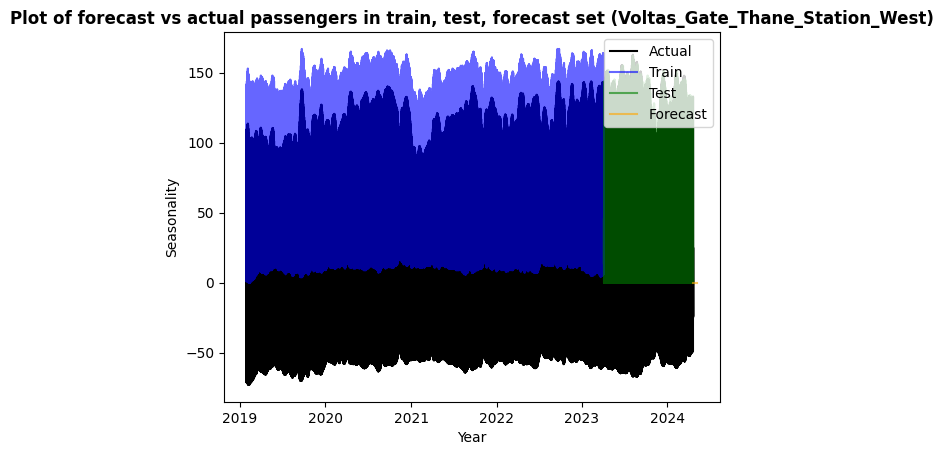

In [115]:
# Load predictions
file1 = pd.read_csv(f"/kaggle/working/Voltas_Gate_Thane_Station_West.csv")
pred = file1['Pred']
pred = np.where(pred < 0, 0, pred)

# Load the model for training predictions
model = tf.keras.models.load_model(f'/kaggle/working/{sp}.keras')
train_pred_inverse = model.predict(X_train_scaled_2)
train_pred_2 = sc_y.inverse_transform(train_pred_inverse)
train_pred = np.floor(train_pred_2)
train_pred = np.where(train_pred < 0, 0, train_pred)

# Load the forecast
forecast = pd.read_csv(f'/kaggle/working/forecast_{sp}.csv')
forecast['Date_Time'] = pd.date_range(pd.Timestamp(2024, 4, 20, 0, 0), pd.Timestamp(2024, 5, 7, 23, 0), freq='1H')

# Plot the results
plt.plot(df['Date_Time'].to_numpy(), df['Seasonal'].to_numpy(), c='black', label='Actual')
plt.plot(df.loc[X_train.index, 'Date_Time'].to_numpy(), train_pred, c='blue', label='Train', alpha=0.6)
plt.plot(df.loc[X_test.index, 'Date_Time'].to_numpy(), pred, c='green', label='Test', alpha=0.6)
plt.plot(forecast['Date_Time'].to_numpy(), forecast['Seasonal'], c='orange', label='Forecast', alpha=0.6)

plt.legend(loc=0)
plt.title(f'Plot of forecast vs actual passengers in train, test, forecast set ({sp})', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Seasonality')
plt.savefig(f'/kaggle/working/{sp}.tiff', format='tiff', dpi=300, bbox_inches='tight')